## M.orygis genome analysis

links:

* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3647658/
* http://bacteria.ensembl.org/Mycobacterium_orygis_112400015/Info/Index
* https://www.frontiersin.org/articles/10.3389/fmicb.2018.02820/full
* https://www.ncbi.nlm.nih.gov/assembly/?term=mycobacterium+orygis

In [1]:
import os, sys, io, random, subprocess
import string
from importlib import reload
import numpy as np
import pandas as pd
pd.set_option('display.width',600)
import seaborn as sns
sns.set_context("talk")
import pylab as plt
from IPython.display import Image
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
from Bio.Align import MultipleSeqAlignment
from Bio import AlignIO, SeqIO

from mtbdiff import utils, analysis

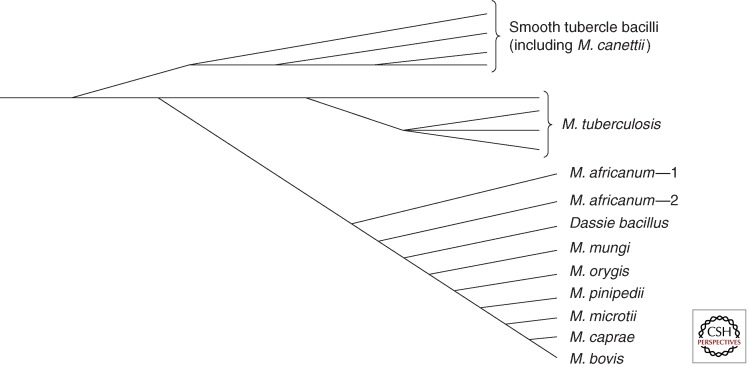

In [2]:
Image('https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4315922/bin/cshperspectmed-TUB-021204_F2.jpg')

## run nucdiff

In [3]:
path = '../myco_genomes'
#names = ['Mbovis','Morygis','Mcaprae','Mmicroti','Mpinnipedii','Mcanettii','Mafricanum']
names = analysis.run_genomes(path, outpath='../myco_results')

../myco_genomes/Morygis_Resp2008.fna Morygis_Resp2008
../myco_genomes/Mafricanum.fna Mafricanum
../myco_genomes/Morygis_NIRTAH144.fna Morygis_NIRTAH144
../myco_genomes/Morygis_Resp2011.fna Morygis_Resp2011
../myco_genomes/Mmicroti.fna Mmicroti
../myco_genomes/Mmungi_BM22813.fna Mmungi_BM22813
../myco_genomes/Mcaprae.fna Mcaprae
../myco_genomes/Morygis_LN2011.fna Morygis_LN2011
../myco_genomes/Mbovis.fna Mbovis
../myco_genomes/Mpinnipedii.fna Mpinnipedii
../myco_genomes/Mcanettii.fna Mcanettii
../myco_genomes/Morygis_112400015.fna Morygis_112400015
../myco_genomes/BCG_Pasteur.fna BCG_Pasteur
../myco_genomes/MTB_beijing.fna MTB_beijing
../myco_genomes/Morygis_Absc2007.fna Morygis_Absc2007


## get nucdiff results
* get RD regions
* get protein annotations

In [4]:
reload(utils)
print (names)

struct, snp =  utils.get_nucdiff_results('../myco_results', names)
#remove reshuffling events?
struct = struct[~struct.Name.str.contains('reshuffling')]
struct = utils.annotate_results(struct)
subcols = ['ID','Name','start','end','length','descr','RD','gene']
print (struct[:4][subcols])

['Morygis_Resp2008', 'Mafricanum', 'Morygis_NIRTAH144', 'Morygis_Resp2011', 'Mmicroti', 'Mmungi_BM22813', 'Mcaprae', 'Morygis_LN2011', 'Mbovis', 'Mpinnipedii', 'Mcanettii', 'Morygis_112400015', 'BCG_Pasteur', 'MTB_beijing', 'Morygis_Absc2007']
       ID              Name  start    end  length                         descr RD   gene
1  SV_100  collapsed_repeat  34787  34802      15  collapsed_repeat_34787:34802  -  bioF2
2   SV_99          deletion  34802  35208     406          deletion_34802:35208  -  bioF2
3   SV_97         insertion  38981  38982       1         insertion_38981:38982  -   None
4   SV_98       duplication  38981  38982       1       duplication_38981:38982  -   None


## presence/absence matrix of events

In [8]:
s = struct[(struct.Name=='deletion') | (struct.Name=='insertion')]
rdmat = utils.RD_matrix(struct)
smat = utils.sites_matrix(s, freq=2)
#snpmat = sites_matrix(snps, freq=5)

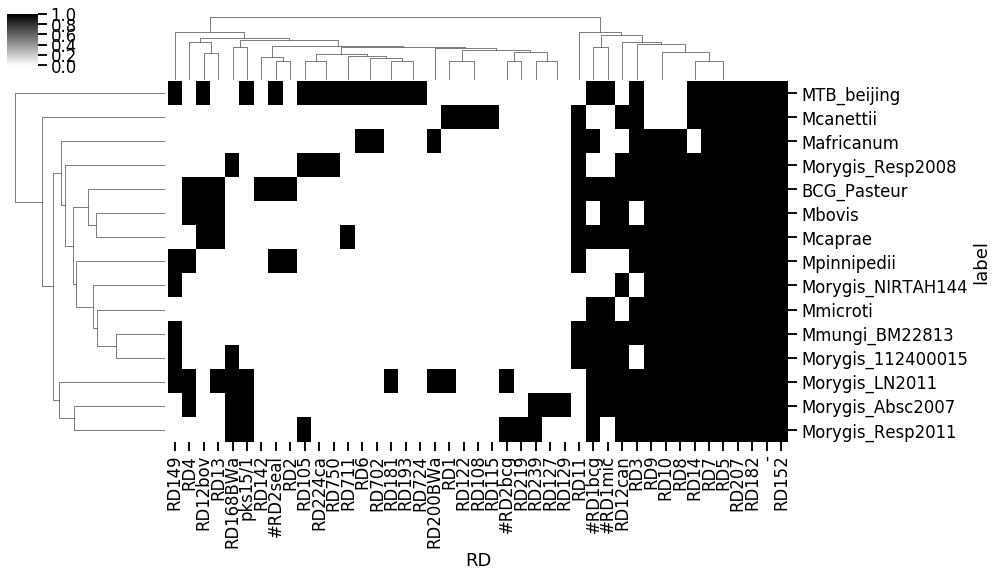

In [9]:
#rds = utils.find_regions(struct)
#x=run_RD_checker(rds)
#plot_RD(x)
fig = analysis.plot_RD(rdmat.T)
fig.savefig('RD_matrix.png',dpi=150)

## find RDs

In [ ]:
def map_regions(coords):
    """Map list of coords to regions of difference and return a dataframe"""
    
    m = []
    RD = pd.read_csv(utils.RD_file,comment='#')
    for c in coords:
        st,end=c
        df = RD[ (st>RD.Start) & (st<RD.Stop) |
                 ((end>RD.Start) & (end<RD.Stop)) |
                 ((st<RD.Start) & (end>RD.Stop))].copy()
        if len(df)>0:
            #print (df)            
            df['start'] = st
            df['end'] = end
            m.append(df)
    m=pd.concat(m)
    return m

m = map_regions(smat.index.values)
#get positions on heatmap of these start locs
#print (m)
xpos = [smat.index.get_loc(i) for i in zip(m.start,m.end)]
labels = list(m.RD_name)
#print (xpos,labels)

#plot heatmap
g=sns.clustermap(smat.T,cbar=False,figsize=(18,7),xticklabels=False,col_cluster=False,cmap='gray_r',lw=1)
ax=g.ax_heatmap
ax.set_title('common indel events in MTC')
for x in xpos:
    ax.axvline(x=x+.5,linewidth=5,color='r',alpha=0.4)
    
plt.sca(ax)
#plt.xticks(xpos, labels)
#l=ax.set_xticklabels(labels,rotation=45)

## check we are detecting RDs properly?

In [ ]:
rx = struct[(struct.label=='Mmicroti') & (~struct.RD.isnull())]
print (rx[cols])

## Compare struct changes between mbovis and orygis 

* get common start sites between the orygis and bovis samples
* common snps?

1871
0 common sites


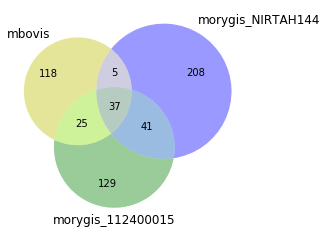

In [7]:
reload(utils)

#print (struct.label.unique())
subset = ['Mbovis', 'Morygis_NIRTAH144','Morygis_112400015','Morygis_LN2011','Morygis_Resp2011']
mb_oryg = struct[struct.label.isin(subset)]
print (len(mb_oryg))
mbdiff = struct[struct.label=='Mbovis']
modiff = struct[struct.label=='Morygis_NIRTAH144']
modiff2 = struct[struct.label=='Morygis_112400015']

from matplotlib_venn import venn3
ax=venn3((set(mbdiff.descr),set(modiff.descr),set(modiff2.descr)),['mbovis','morygis_NIRTAH144','morygis_112400015'],('y','b','g'))

mat = utils.sites_matrix(mb_oryg, index='descr')
mat = mat[mat.sum(1)>3]
intersect = mat.index

comm = modiff[modiff.descr.isin(intersect)]
comm = comm[subcols]
print('%s common sites' %len(comm))
#print (comm.groupby('Name').size())

In [9]:
comm=comm.sort_values('length',ascending=False)
comm.to_csv('morygis_common.csv')
comm

,ID,Name,start,end,length,descr,RD,gene


In [ ]:
struct.columns
x = pd.pivot_table(struct, index='Name',columns=['species'],aggfunc='count')
x=x.fillna(0)
x

## look at features on the genome viewer

In [198]:
reload(viewers)
gff1 = analysis.mtb_gff
gff2 = '../test_results/MTB-H37Rv_Mbovis/results/query_ref_struct.gff'
feats = utils.gff_to_features(gff2)
p=viewers.view_features(feats)
p

(1, 20000) 5000


Column
    [0] Row
        [0] TextInput(name='gff file')
        [1] TextInput(name='location', value='1:20000', width=200)
        [2] TextInput(name='find_gene', width=200)
        [3] Button(button_type='primary', name='-', width=40)
        [4] Str(int, style={'margin': '4pt'}, width=180)
    [1] IntRangeSlider(end=1000000, step=10, value=(1, 20000), width=900)
    [2] Column(sizing_mode='stretch_width')
        [0] Bokeh(Figure, height=100, margin=10)